In [2]:
import cv2
try:
    cv2.setNumThreads(0)
    print ("NumThreads for cv2 ... set!")
except:
    pass

import numpy as np
import pandas as pd
import os

import caiman as cm
from caiman.motion_correction import MotionCorrect

from sys import path as syspath
syspath.append(os.path.expanduser("~/srdjan_functs/"))
from physio_def_1 import rebin

NumThreads for cv2 ... set!


In [3]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# Importing

In [4]:
npzFiles = [
    "local_data/Sandra/2020_01_14/Experiment45b/Experiment45b_1_Series006.npz",
    "local_data/Sandra/2020_01_14/Experiment45b/Experiment45b_2_Series007.npz",
    "local_data/Sandra/2020_01_14/Experiment45b/Experiment45b_3_Series008.npz"
#     "local_data/testdir/Experiment38a_18_Series040.npz"
]
# npzFile = f"/Volumes/physio/team/slakrupnik/project/experiments/Sandra/{row.date}/{row.filename.split('_')[0]}/{row.filename}.npz"
metadata = pd.DataFrame([pd.read_csv(npzFile.replace("npz","txt")).loc[0] for npzFile in npzFiles])

In [5]:
if len(metadata)>1:
    assert metadata.X.std()==0
    assert metadata.Y.std()==0
    assert metadata.freq.std()/metadata.freq.mean()<1e-3
    print ((metadata["T"]/metadata["freq"]/60).sum(), "minutes")
    origFreq = metadata.freq.mean()
    metadata["T"] = metadata["T"].sum()
    metadata = pd.Series(metadata.iloc[0])
    metadata["freq"] = origFreq
else:
    metadata = metadata.iloc[0]
    origFreq = metadata.freq
    print (metadata["T"]/metadata.freq/60, "minutes")

65.62319308464636 minutes


In [7]:
from physio_def_1 import import_npz_files

In [8]:
orig_images = import_npz_files(npzFiles)

# Perform Motion Correction on rebinned movie

## prepare rebinned movie

In [9]:
# subsampling frequency for Motion Correction
freqMC = 3
n_rebin = int(metadata.freq/freqMC)
n_rebin

28

In [10]:
rebinned_images = rebin(orig_images,n_rebin).astype("float32")
base_name = "tmp"

In [11]:
#%% start a cluster for parallel processing (if a cluster already exists it will be closed and a new session will be opened)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

In [12]:
fnames = cm.save_memmap([rebinned_images], base_name=base_name, order='C', border_to_0=0, dview=dview)

## Create MotionCorrection object

In [13]:
from caiman.source_extraction.cnmf import params as params

In [14]:
# motion correction parameters
opts = params.CNMFParams(params_dict={
    'fnames'              : fnames,
    "max_deviation_rigid" : 0,
    # 'max_shifts'        : (1, 1),  # maximum allowed rigid shift
    'border_nan'          : "copy",
    # 'pw_rigid'            : None,
    'gSig_filt'           : (2, 2),  # size of high pass spatial filtering, used in 1p data,
    'nonneg_movie'        : True
}) 

mc = MotionCorrect(fnames, dview=dview, **opts.get_group('motion'))

In [15]:
pipeline = ["rigid","flex"]

## Rigid

constraining mc.max_deviation_rigid at  0


constraining mc.max_deviation_rigid at  1


constraining mc.max_deviation_rigid at  2


100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


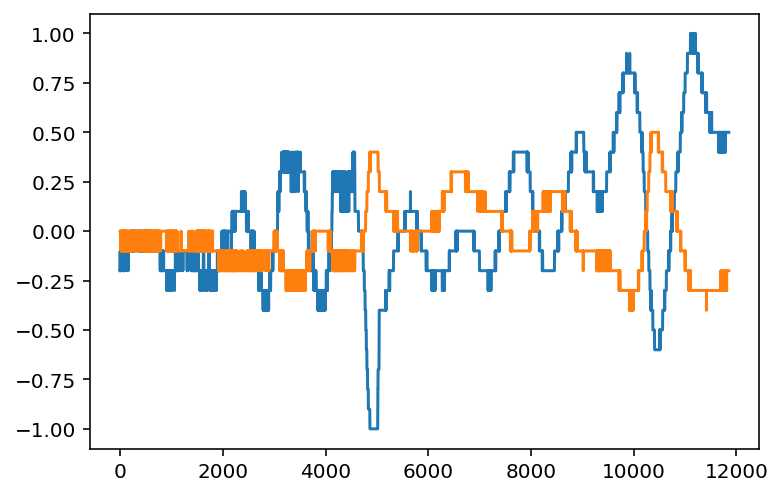

In [16]:
if "rigid" in pipeline:
    while True:
        print ("constraining mc.max_deviation_rigid at ", mc.max_deviation_rigid)
        mc.motion_correct(save_movie=True);
        maxshift = np.abs(mc.shifts_rig).max()
        if maxshift<mc.max_deviation_rigid:
            break
        else:
            mc.max_deviation_rigid += 1
    mc.shifts_rig = np.array(mc.shifts_rig)
    plt.plot(mc.shifts_rig)
    m_after_rigid = cm.load(mc.fname_tot_rig)

### Compare in video

In [101]:
if "m_rebinned" not in globals():
    m_rebinned = cm.load(mc.fname)
m_after_rigid   = cm.load(mc.fname_tot_rig)

100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


In [26]:
m_rebinned.shape, m_after_rigid.shape

((3951, 128, 128), (3951, 128, 128))

In [27]:
from physio_def_1 import showMovie

In [30]:
nRebinShow = len(m_rebinned)//300

In [37]:
# border = rebin(np.ones_like(m_rebinned[:,:1])*m_rebinned.max(), nRebinShow)
# showMovie(np.log(cm.concatenate([
#     rebin(m_rebinned, nRebinShow),
#     border,
#     rebin(m_after_rigid, nRebinShow),
# ],axis=1)),figsize=(13,6))

## "Flexible"

In [17]:
if "flex" in pipeline:
    patchSizeAbs = 80 # in micrometers
    patchSizePx = int(patchSizeAbs/metadata.pxSize)
    if patchSizePx%2:
        patchSizePx -= 1

    Lstride = int(patchSizePx*.7)
    Loverlap = patchSizePx - Lstride
    print (Lstride, Loverlap)

    mc.strides  = (Lstride,)*2   # start a new patch for pw-rigid motion correction every x pixels,
    mc.overlaps = (Loverlap,)*2  # between pathes (size of patch strides+overlaps),


    # % For setting the number of patches per dimension
    # nStridesX, nStridesY = 8,8
    # LstrideX = int(metadata.X*metadata.pxSize/patchSize)
    # LoverlapX = LstrideX//2+1
    # LstrideY = int(metadata.Y*metadata.pxSize/patchSize)
    # LoverlapY = LstrideY//2+1
    # # LstrideX, LoverlapX = metadata.X//nStridesX, metadata.X%nStridesX  
    # # LstrideY, LoverlapY = metadata.Y//nStridesY, metadata.Y%nStridesY  
    # # LstrideX, LoverlapX = dims[0]//nStridesX, dims[0]%nStridesX  
    # # LstrideY, LoverlapY = dims[1]//nStridesY, dims[1]%nStridesY  
    # LstrideX, LoverlapX, LstrideY, LoverlapY
    # mc.strides  = ( LstrideX,  LstrideY)   # start a new patch for pw-rigid motion correction every x pixels,
    # mc.overlaps = (LoverlapX, LoverlapY)   # between pathes (size of patch strides+overlaps),

    mc.max_deviation_rigid = 2  # maximum deviation allowed for patch with respect to rigid shifts

    mc.pw_rigid = True  # turn the flag to True for pw-rigid motion correction
    mc.motion_correct(save_movie=True, template=mc.total_template_rig)

28 12


### Plot corrections

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


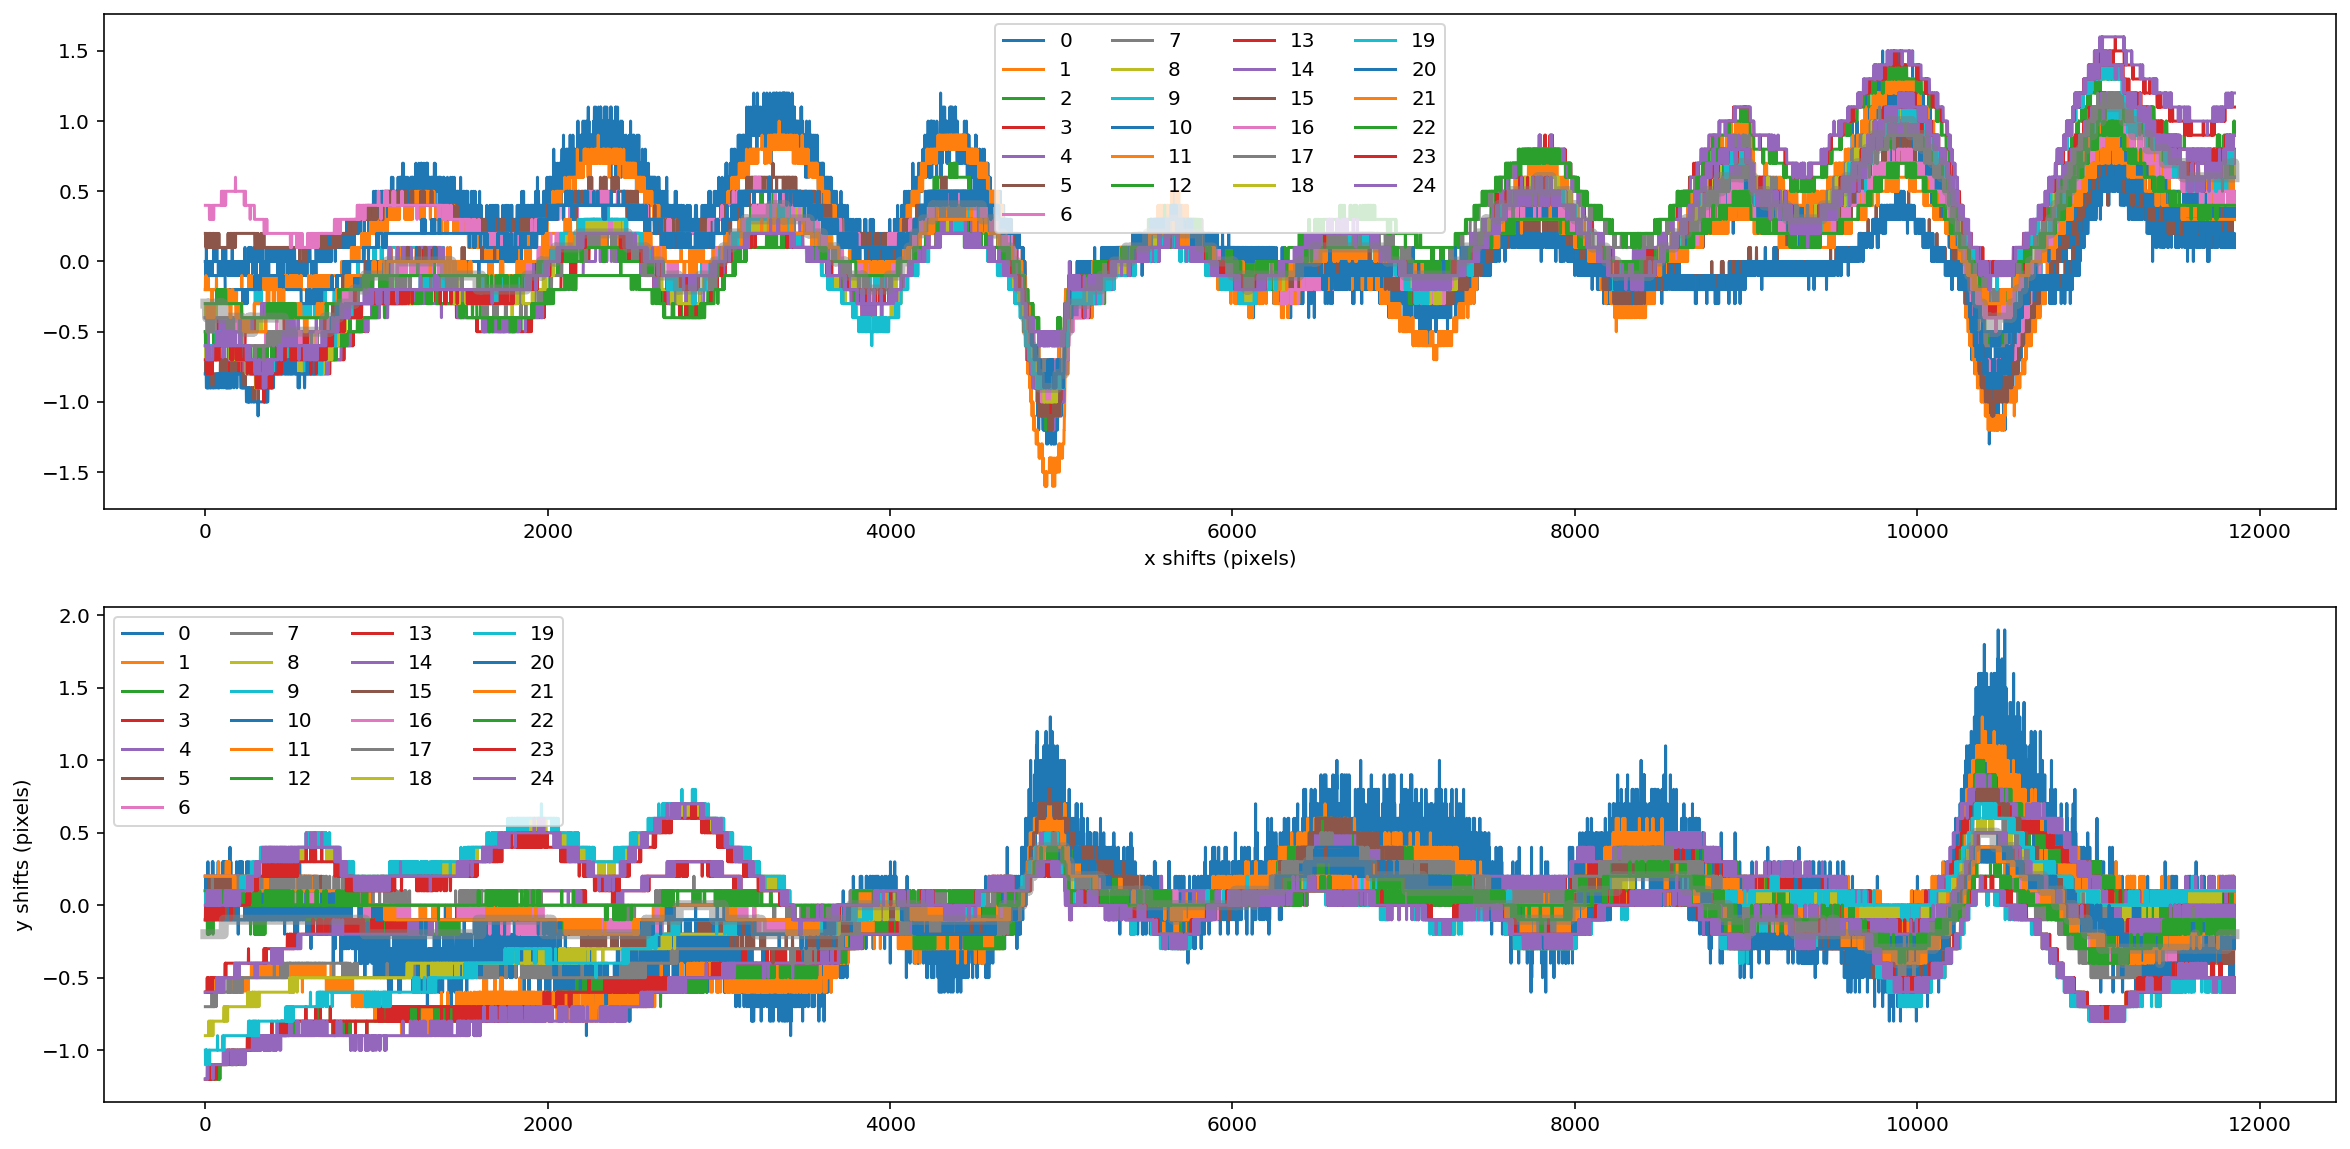

In [19]:
mc.x_shifts_els = np.array(mc.x_shifts_els)
mc.y_shifts_els = np.array(mc.y_shifts_els)
mc.shifts_rig = np.array(mc.shifts_rig)

#%% visualize elastic shifts
plt.close()
fig, axs = plt.subplots(2,1,figsize = (20,10))

for i in range(mc.x_shifts_els.shape[1]):
# for i in range(1):
    c = plt.plot([])[0].get_color()
    for x,ax in zip([mc.x_shifts_els[:,i],mc.y_shifts_els[:,i]],axs):
        ax.plot(x,label=i,c=c)
for j in [0,1]:
    axs[j].plot(mc.shifts_rig.T[j],"grey",lw=5,alpha = .5)
    
if i<=24:
    for ax in axs:
        ax.legend(ncol=4)
axs[0].set_xlabel('x shifts (pixels)')
axs[1].set_ylabel('y shifts (pixels)')

bord_px_els = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els)),
                                 np.max(np.abs(mc.y_shifts_els)))).astype(np.int)

## Check and compare the template

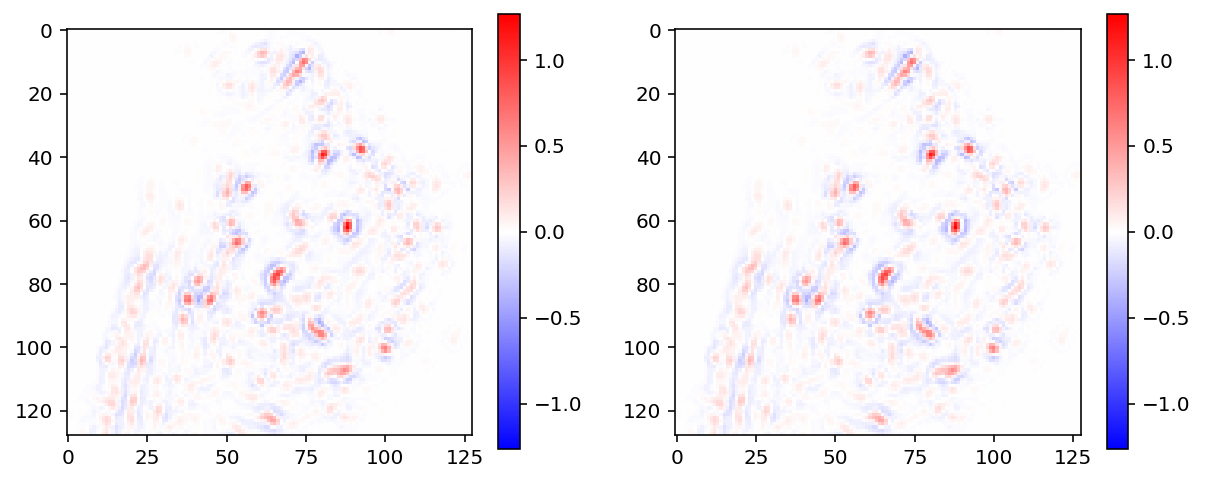

In [19]:
fig, axs = plt.subplots(1,2,figsize=(10,4))
for ax,x in zip(axs, [mc.total_template_rig,mc.total_template_els]):
    im = ax.imshow(x.T,vmin=-np.abs(x).max(),vmax= np.abs(x).max(), cmap="bwr")
    plt.colorbar(im, ax = ax)

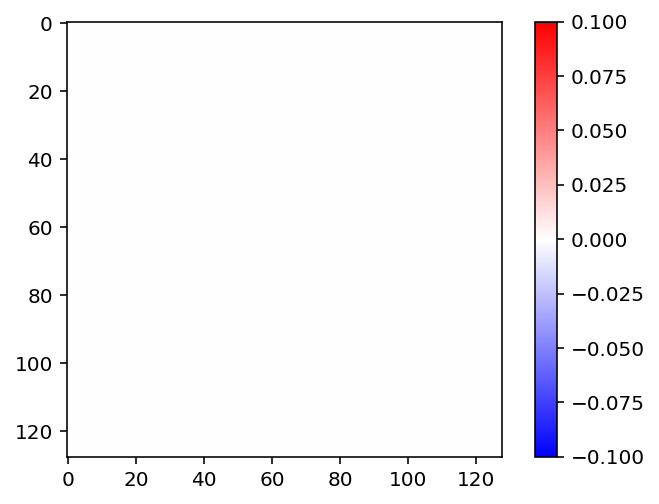

In [20]:
x = mc.total_template_els - mc.total_template_rig
plt.imshow(x.T,vmin=-np.abs(x).max(),vmax= np.abs(x).max(), cmap="bwr")
plt.colorbar()

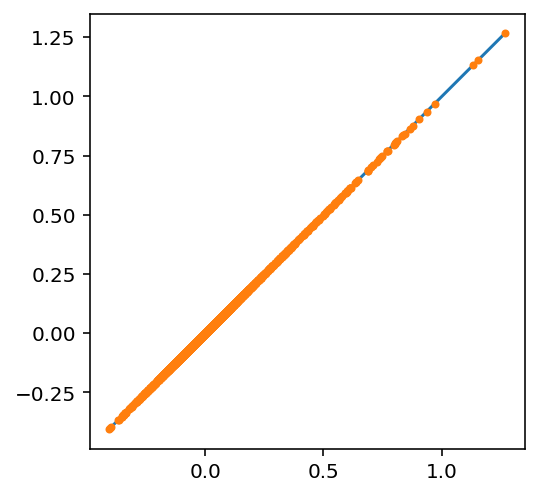

In [21]:
plt.plot(*[[mc.total_template_rig.min(),mc.total_template_rig.max()]]*2)
plt.plot(mc.total_template_rig.flatten(),mc.total_template_els.flatten(),'.')
plt.gca().set_aspect("equal")

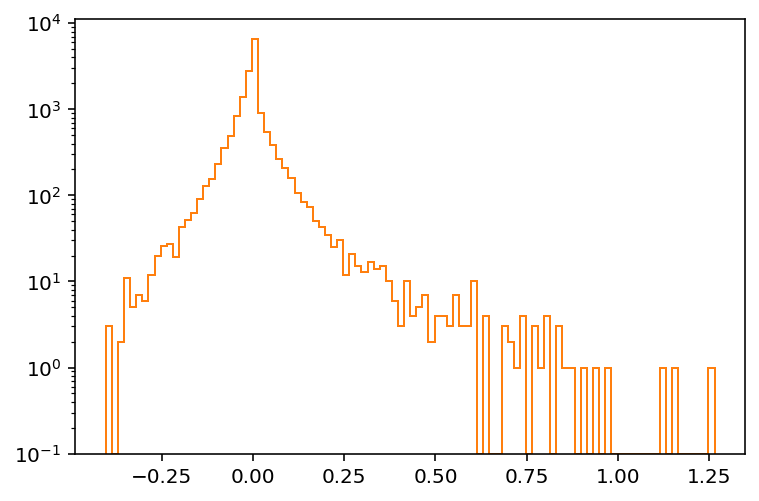

In [22]:
for x in [mc.total_template_rig,mc.total_template_els]:
    x = x.flatten()
    plt.hist(x,100,log=True, histtype="step")

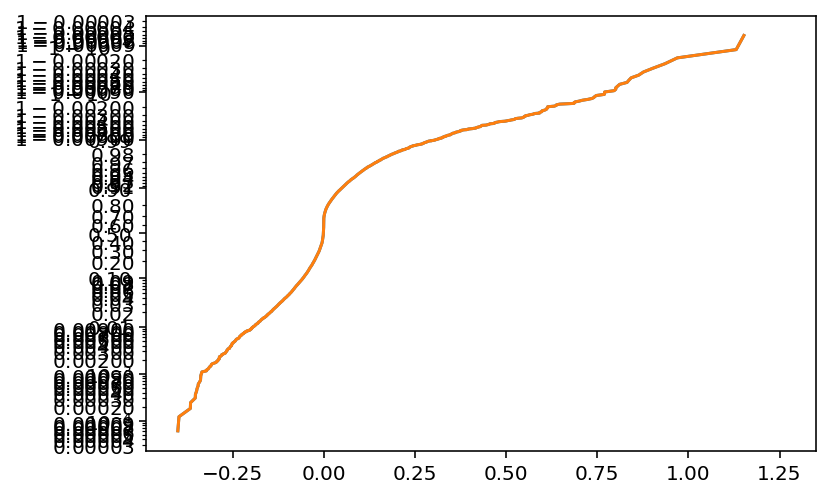

In [23]:
for x in [mc.total_template_rig,mc.total_template_els]:
    x = x.flatten()
    x.sort()
    plt.plot(x,np.linspace(0,1,len(x)))
plt.yscale("logit")

## Compare in video

In [24]:
if "m_rebinned" not in globals():
    m_rebinned = cm.load(mc.fname)
m_after_pwrigid = cm.load(mc.fname_tot_els)

100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


In [25]:
from physio_def_1 import showMovie

In [26]:
mth = m_rebinned.min()
print (mth)

1e-04


In [27]:
m_after_pwrigid[m_after_pwrigid<mth] = mth

In [28]:
nRebinShow = len(m_rebinned)//100

In [20]:
# border = rebin(np.ones_like(m_rebinned[:,:1])*m_rebinned.max(), nRebinShow)
# showMovie(np.log(cm.concatenate([
#     rebin(m_rebinned, nRebinShow),
#     border,
#     rebin(m_after_rigid, nRebinShow),
#     border,
#     rebin(m_after_pwrigid, nRebinShow),
# ],axis=1)),figsize=(13,6))

In [30]:
m_diff = m_after_pwrigid - m_after_rigid

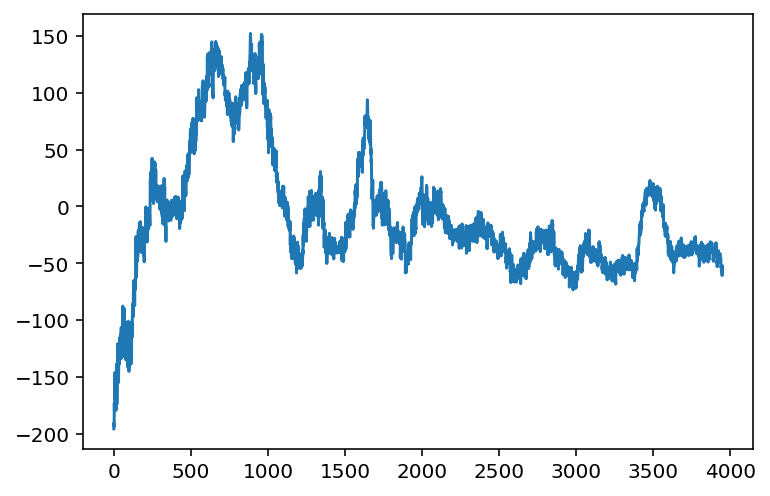

In [32]:
plt.plot(m_diff.sum(axis=(1,2)))

# Stretch shifts to encompass the whole origial movie

## begin

In [18]:
mc.x_shifts_els = np.array(mc.x_shifts_els)
mc.y_shifts_els = np.array(mc.y_shifts_els)

In [19]:
origShifts = np.stack([mc.x_shifts_els,mc.y_shifts_els])

In [20]:
from numeric import runningAverage

In [21]:
%%capture
runningAverage(origShifts,11)

In [22]:
expanded_shifts = cm.movie(origShifts.transpose((1,0,2))).resize(1,1,n_rebin)
print (expanded_shifts.shape)
n_expand = n_rebin*10
if not n_expand%2:
    n_expand -= 1
expanded_shifts = runningAverage(expanded_shifts,n_expand)
expanded_shifts = expanded_shifts.transpose((1,0,2))
# print (expanded_shifts.shape)

(331912, 2, 25)


In [23]:
rpad = orig_images.shape[0]-expanded_shifts.shape[1]
rpad = np.repeat(expanded_shifts[:,[-1]], rpad, axis=1)
expanded_shifts = np.concatenate([expanded_shifts,rpad],axis=1)

## plotting

In [28]:
time = np.arange(len(orig_images))/metadata.freq

In [89]:
%matplotlib notebook

<IPython.core.display.Javascript object>


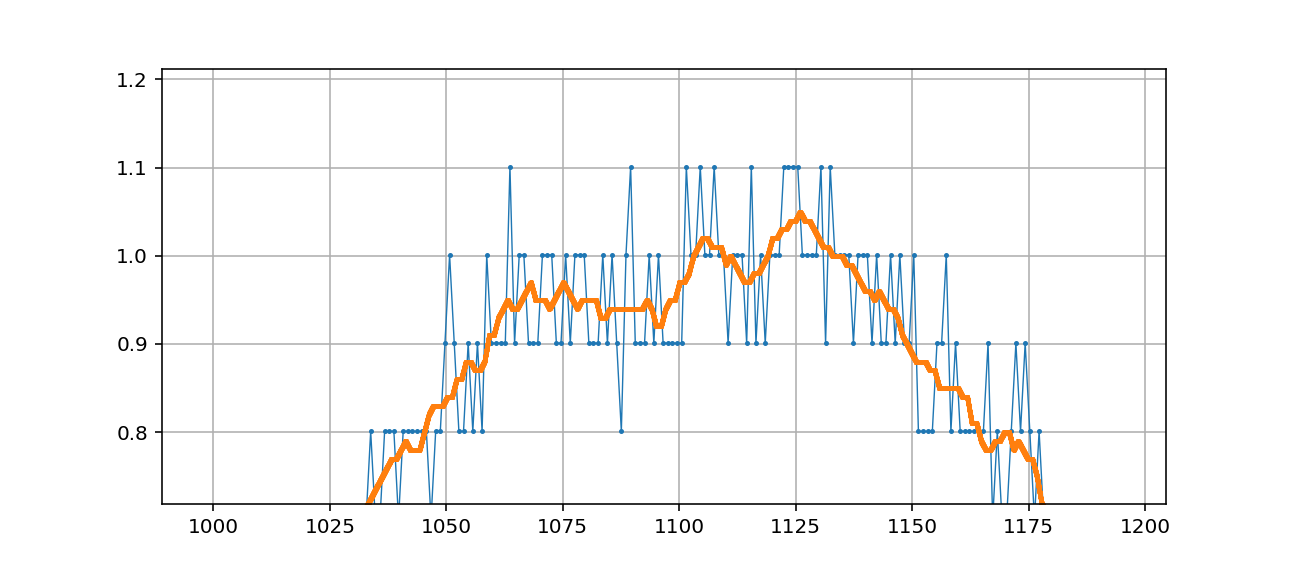

In [98]:


plt.figure(figsize=(9,4))
i,j = 0,0
# plt.plot(np.linspace(0,1,len(m_rebinned)),origShifts[i,:,j],".-")
plt.plot(rebin(time, n_rebin),origShifts[i,:,j]+1e-3,".-",ms=3,lw=.7)
plt.plot(time,expanded_shifts[i,:,j],".",ms=3,lw=.7)
plt.grid()
# plt.xlim(0,2)
# plt.ylim(-.12,.02)

## Continue

In [ ]:
assert expanded_shifts.shape[1] == orig_images.shape[0]

batch = int(4e3)

nIters = int(np.ceil(len(orig_images)/batch))
mshifted = []
for i in range(nIters):
    tmpSlice = slice(i*batch,(i+1)*batch)
    mc.x_shifts_els, mc.y_shifts_els = expanded_shifts[:,tmpSlice]
    fname_orig = cm.save_memmap([orig_images[tmpSlice]], base_name="orig", order='C', border_to_0=0, dview=dview)
    mshifted += [mc.apply_shifts_movie(fname_orig).astype("float16")]
#     break

mshifted = np.concatenate(mshifted)

In [ ]:
from physio_def_1 import getBaseName

In [ ]:
baseName = getBaseName(npzFiles)

In [ ]:
saveName = baseName+"_motcor.npz"

In [ ]:
th = orig_images.min()
for m in ["orig_images","m_after_rigid","m_after_pwrigid","mshifted"][::-1]:
    try:
        x = eval(m)
        x = x[::len(x)//100,::3,::3].flatten()
    except:
        continue
    c = plt.plot([])[0].get_color()
    x.sort()
#     for x,ls in zip([x,x[x>th]],["--","-"]):
    for ls in["--","-"]:
        if len(ls)==1:
            x[x<th] = th

        plt.plot(x,np.linspace(0,1,len(x)),lw=1,label=m,ls=ls,c=c)
plt.xscale("symlog")
plt.yscale("logit")
plt.legend()

In [56]:
mshifted[mshifted<th] = th

In [69]:
x = orig_images[:10].flatten()
ii = np.argpartition(-x.astype("float"),3)

In [70]:
x[ii[:3]]

array([0, 0, 0], dtype=uint8)

In [ ]:
del m_after_rigid

In [ ]:
mshifted.flatten()[ii[:3]]

In [ ]:
np.savez_compressed(saveName,data=mshifted,template=mc.total_template_els)

In [29]:
saveName

'local_data/Sandra/2020_01_14/Experiment45b/Experiment45b_1_Series006-008_motcor.npz'

In [41]:
mshifted.dtype, mshifted.shape

(dtype('float16'), (331933, 128, 128))

In [42]:
orig_images.shape, mshifted.shape

((331933, 128, 128), (331933, 128, 128))

In [58]:
cm.stop_server(dview=dview) # stop the server

# Compare all in video

In [ ]:
# fname_orig = cm.save_memmap([orig_images], base_name="orig", order='C', border_to_0=0, dview=dview)
# del orig_images

# fname_corr = cm.save_memmap([mshifted   ], base_name="corr", order='C', border_to_0=0, dview=dview)
# del mshifted

# m_orig = cm.load(fname_orig)
# m_corr = cm.load(fname_corr)

In [ ]:
m_orig = cm.movie(orig_images)

In [ ]:
# m_corr[m_corr<th] = th

In [ ]:
from physio_def_1 import showMovie

In [ ]:
timeSlice = slice(int(len(m_orig)*.6),int(len(m_orig)*.7))

In [ ]:
timeSlice

In [ ]:
nTimeFrames = 100
nRebinShow = len(m_orig[timeSlice])//nTimeFrames
border = np.ones((nTimeFrames,1,m_orig.shape[-1]))*m_orig.max()
m2show = cm.concatenate([
    rebin(m_orig[timeSlice], nRebinShow),
    border,
    rebin(m_corr[timeSlice], nRebinShow),
],axis=1)

In [ ]:
m2show[m2show<th] = th

In [ ]:
showMovie(np.log(m2show),figsize=(13,6))

In [37]:
m2show.shape

NameError: name 'm2show' is not defined

## Quality assessment 

Apart from inspection, the performance of the registration methods can be quantified using several measures. Below we compute measures such as correlation of each frame with mean, crispness of summary image, and residual optical flow for all three cases. For more info see [[1]](#normcorre). Note that computation of the residual optical flow can be computationally intensive.

In [33]:
%%time 
%%capture
#% compute metrics for the results (TAKES TIME!!)
final_size = np.subtract(mc.total_template_els.shape, 2 * bord_px_els) # remove pixels in the boundaries
winsize = 100
swap_dim = False
resize_fact_flow = .2    # downsample for computing ROF

tmpl_rig, correlations_orig, flows_orig, norms_orig, crispness_orig = cm.motion_correction.compute_metrics_motion_correction(
    fnames[0], final_size[0], final_size[1], swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

tmpl_rig, correlations_rig, flows_rig, norms_rig, crispness_rig = cm.motion_correction.compute_metrics_motion_correction(
    mc.fname_tot_rig[0], final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

tmpl_els, correlations_els, flows_els, norms_els, crispness_els = cm.motion_correction.compute_metrics_motion_correction(
    mc.fname_tot_els[0], final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

CPU times: user 56.1 s, sys: 5.1 s, total: 1min 1s
Wall time: 1min 3s


In [39]:
from matplotlib.colors import LogNorm

In [29]:
# m = m_orig[:100].mean(0)
# # plt.imshow(m-m.min()+1,norm=LogNorm())
# plt.imshow(m.max()-m-1,)

In [36]:
m_orig[:10].sum(axis=0)

movie([[-2557., -2673., -2681., ..., -2625., -2679., -2642.],
       [-2272., -2526., -2374., ..., -2638., -2473., -2579.],
       [-2595., -2705., -2646., ..., -2574., -2583., -2595.],
       ...,
       [-2695., -2726., -2668., ..., -2385., -2384., -2750.],
       [-2678., -2731., -2768., ..., -2640., -2693., -2676.],
       [-2696., -2705., -2772., ..., -2377., -2513., -2573.]],
      dtype=float32)

In [35]:
m_rig.dtype

dtype('float32')

Plot correlation with mean frame for each dataset

In [28]:
# plt.figure(figsize = (20,10))
# plt.subplot(211); plt.plot(correlations_orig); plt.plot(correlations_rig); plt.plot(correlations_els)
# plt.legend(['Original','Rigid','PW-Rigid'])
# plt.subplot(223); plt.scatter(correlations_orig, correlations_rig); plt.xlabel('Original'); 
# plt.ylabel('Rigid'); plt.plot([0.3,0.7],[0.3,0.7],'r--')
# axes = plt.gca(); axes.set_xlim([0.3,0.7]); axes.set_ylim([0.3,0.7]); plt.axis('square');
# plt.subplot(224); plt.scatter(correlations_rig, correlations_els); plt.xlabel('Rigid'); 
# plt.ylabel('PW-Rigid'); plt.plot([0.3,0.7],[0.3,0.7],'r--')
# axes = plt.gca(); axes.set_xlim([0.3,0.7]); axes.set_ylim([0.3,0.7]); plt.axis('square');


In [48]:
# print crispness values
print('Crispness original: '+ str(int(crispness_orig)))
print('Crispness rigid: '+ str(int(crispness_rig)))
print('Crispness elastic: '+ str(int(crispness_els)))

Crispness original: 1937
Crispness rigid: 2759
Crispness elastic: 2847


In [27]:
# #%% plot the results of Residual Optical Flow
# fls = [mc.fname_tot_els[0][:-4] + '_metrics.npz', mc.fname_tot_rig[0][:-4] +
#        '_metrics.npz', mc.fname[0][:-4] + '_metrics.npz']

# plt.figure(figsize = (20,10))
# for cnt, fl, metr in zip(range(len(fls)),fls,['pw_rigid','rigid','raw']):
#     with np.load(fl) as ld:
#         print(ld.keys())
#         print(fl)
#         print(str(np.mean(ld['norms'])) + '+/-' + str(np.std(ld['norms'])) +
#               ' ; ' + str(ld['smoothness']) + ' ; ' + str(ld['smoothness_corr']))
        
#         plt.subplot(len(fls), 3, 1 + 3 * cnt)
#         plt.ylabel(metr)
#         try:
#             mean_img = np.mean(
#             cm.load(fl[:-12] + 'mmap'), 0)[12:-12, 12:-12]
#         except:
#             try:
#                 mean_img = np.mean(
#                     cm.load(fl[:-12] + '.tif'), 0)[12:-12, 12:-12]
#             except:
#                 mean_img = np.mean(
#                     cm.load(fl[:-12] + 'hdf5'), 0)[12:-12, 12:-12]
                    
#         lq, hq = np.nanpercentile(mean_img, [.5, 99.5])
#         plt.imshow(mean_img, vmin=lq, vmax=hq)
#         plt.title('Mean')
#         plt.subplot(len(fls), 3, 3 * cnt + 2)
#         plt.imshow(ld['img_corr'], vmin=0, vmax=.35)
#         plt.title('Corr image')
#         plt.subplot(len(fls), 3, 3 * cnt + 3)
#         #plt.plot(ld['norms'])
#         #plt.xlabel('frame')
#         #plt.ylabel('norm opt flow')
#         #plt.subplot(len(fls), 3, 3 * cnt + 3)
#         flows = ld['flows']
#         plt.imshow(np.mean(
#         np.sqrt(flows[:, :, :, 0]**2 + flows[:, :, :, 1]**2), 0), vmin=0, vmax=0.3)
#         plt.colorbar()
#         plt.title('Mean optical flow')      